In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
import os
import glob
import parsing

In [2]:
def get_merged_data(city) -> pd.DataFrame:
    """returns merged df of all the districts"""

    def get_raion_file(ind: int) -> pd.DataFrame:
        """take a raion files and returns df with raion name column"""
        file_data = pd.read_excel(list_of_files[ind])
        if not file_data.empty:
            file_data['raion_name'] = regions["raion_name"][ind]
        else:
            file_data = pd.DataFrame(data={'raion_name': [regions["raion_name"][ind]]})
        return file_data

    # read cian data
    path_to_cian_data = os.path.join(os.getcwd(), f"{city}_files", "")
    list_of_files = glob.glob(path_to_cian_data + "*.xlsx")
    # sort cian data by the time of download
    list_of_files.sort(key=os.path.getctime)

    offers_data = pd.DataFrame()
    for i in range(len(list_of_files)):
        raion_data = get_raion_file(i)
        offers_data = pd.concat([offers_data, raion_data], join='outer', ignore_index=True)

    return offers_data


In [3]:
def print_heat_map(data):
    fig, ax = plt.subplots(1, figsize=(40, 20))
    ax.axis('off')
    ax.set_title(F'Average appartment square meter price in {city.capitalize()} districts, rubles',
                 fontdict={'fontsize': '40', 'fontweight': '3'})

    # price borders
    vmin, vmax, vmean = data.average_price.min(), \
                        data.average_price.max(), data.average_price.mean()

    color = 'Blues'
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=20)

    data.plot('average_price', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40, 20))

    lower_bound, upper_bound = 5 / 8 * vmin + 3 / 8 * vmax, 5 / 8 * vmax + 3 / 8 * vmin
    # lower_bound, upper_bound = vmean, 3/4 * vmax + 1/4 * vmin
    for idx, row in data.iterrows():
        if lower_bound < row['average_price'] and row['average_price'] < upper_bound:
            plt.annotate(text=idx, xy=np.concatenate(row["center"].coords.xy),
                         horizontalalignment='left', fontsize='large', color='black', wrap=True)

    plt.show()
    

In [4]:
def heat_city(city):
    def get_average_price_data(offers):
        """returns df with average price in each district"""
        # add price and square columns
        offers["price"] = offers["Цена"].str.replace(' .+', '').astype(float)
        offers["square"] = offers["Площадь, м2"].str.replace('/.+', '').astype(float)
        # aggregate price and square data
        price_data = offers.groupby("raion_name").agg({"price": "sum", "square": "sum"})
        # calculate average price
        price_data["average_price"] = price_data.price / price_data.square
        # saort data by average price in descending order
        price_data.sort_values("average_price", ascending=False)

        return price_data

    global regions
    offers_data = get_merged_data(city)
    price_data = get_average_price_data(offers_data)

    # megred contains average price, geometry, and polygon center
    merged_df = regions.set_index('raion_name').join(price_data[["average_price"]])
    merged_df["center"] = merged_df.geometry.apply(lambda x: x.centroid)

    print_heat_map(merged_df)
    # end


In [5]:
def get_regions_data(city) -> pd.DataFrame:
    # read polygon data
    path_to_geo_data = os.path.join(os.getcwd(), 'forAnalysis', f'{city}.csv')
    return gpd.read_file(path_to_geo_data, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")


In [6]:
def city_input() -> str:
    """returns city name by entered index"""
    city_index = input("Enter the number of the city you want: "
                       "\n1 — Moscow;\n2 — SPB;\n3 — Ekaterinburg.\n").strip()
    if city_index not in ('1', '2', '3'):
        while True:
            city_index = input("Please, enter correct number of a city: "
                               "1 — Moscow; 2 — SPB; 3 — Ekaterinburg.\n").strip()
            if city_index in ('1', '2', '3'):
                break
    return ("moscow", "spb", 'ekaterinburg')[int(city_index) - 1]


Enter the number of the city you want: 
1 — Moscow;
2 — SPB;
3 — Ekaterinburg.
3


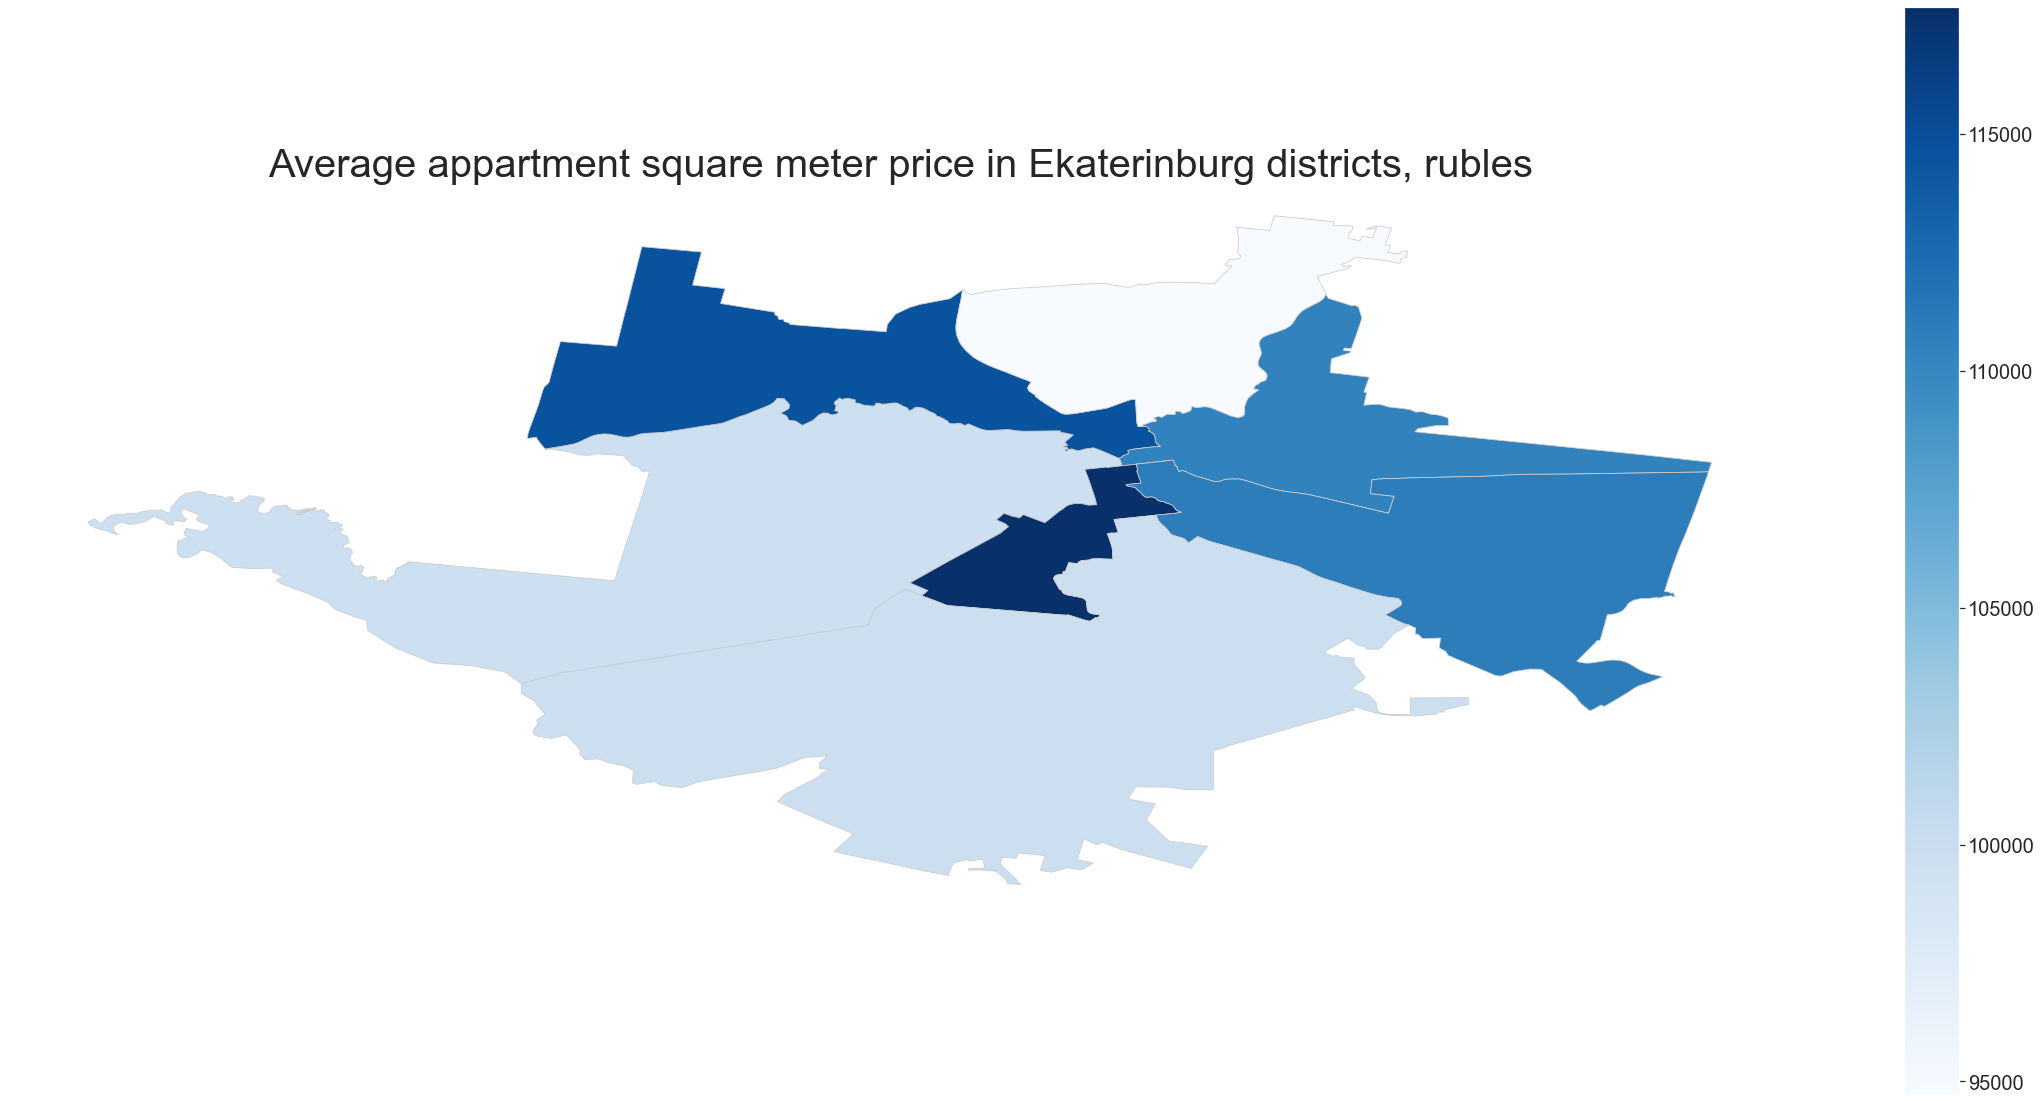

In [7]:
if __name__ == "__main__":
    city = city_input()

    # read polygon data
    regions = get_regions_data(city)

    parsing.download_files(regions, city)

    msc = get_merged_data(city)
    heat_city(city)
